# Overview

## Output Files:
- SQGDP9_US_2005_2022.csv
- Aon_US_Damage_2004_to_2022.csv
- Aon_US_Damage_2004_to_2022_dropped.csv
- rsmeans_wtavgs_st.csv
- nationwide_constr_spend_qtr.csv

## BEA Construction Data

### Input:
- SQGDP9_AK_2005_2022.csv
- SQGDP9_AL_2005_2022.csv
- ...
- SQGDP9_WV_2005_2022.csv
- SQGDP9_WY_2005_2022.csv

### Output:
- SQGDP9_US_2005_2022.csv

## AON Damages Data

### Input: 
- Aon Damages by Time Location and Amount 2004 to 2022.xlsx

### Output:  
- Aon_US_Damage_2004_to_2022.csv
- Aon_US_Damage_2004_to_2022_dropped.csv

## RSMeans Data

### Input:
- rsmeans.pkl

### Output:
- rsmeans.csv

## US Construction GDP Data

### Input:
- nationwide_constr_spend.xlsx

### Output:
- nationwide_constr_spend_qtr.csv

## Preliminaries

In [1]:
# set to true to create output files again
create_output_files = False
chunk_size = 200000
#chunk_size=2

In [2]:
import pandas as pd
import numpy as np
import re
import glob
import os
import pickle
import datetime
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from scipy.stats import rvs_ratio_uniforms
from sympy import *
import sympy
import scipy.stats as stats

### Files and Directories

In [3]:
# Base
#base_dir = "./Rich"
base_dir = '/content/drive/MyDrive/environment'
out_dir = os.path.join(base_dir,"out2")

# FEMA
fema_in_file = "HELP HELP.xlsx"
#fema_in_file = "HELP HELP2.xlsx"
fema_fed_out_file = "fema_fed_by_month"     # .csv added later
fema_st_out_file = "fema_state_by_month"    # .csv added later
fema_tot_out_file = "fema_total_by_month"   # .csv added later

fema_err_dt1_out_file = "fema_err_start_date.csv"
fema_err_dt2_out_file = "fema_err_end_date.csv"
fema_err_dt2_lt_dt1_file = "fema_err_start_date_gt_end_date.csv"
fema_err_tot_spend = "fema_err_total_spend.csv"
fema_err_fed_spend = "fema_err_fed_spend.csv"
fema_err_st_spend = "fema_err_state_spend.csv"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Process FEMA

In [5]:
def clean_up_file(filename,appendcsv=False):
    filenpath = os.path.join(base_dir,filename+(".csv" if appendcsv else ""))
    if os.path.exists(filenpath):
        os.remove(filenpath)

In [6]:
clean_up_file(fema_fed_out_file)
clean_up_file(fema_st_out_file)
clean_up_file(fema_tot_out_file)
clean_up_file(fema_err_dt1_out_file)
clean_up_file(fema_err_dt2_out_file)
clean_up_file(fema_err_dt2_lt_dt1_file)
clean_up_file(fema_err_tot_spend,True)
clean_up_file(fema_err_fed_spend,True)
clean_up_file(fema_err_st_spend,True)

In [7]:
dffema = None   # master set
dti = None
df = None       # chunk set
use_gaussian = True
cdfbins = 1000
cdftot = 1000000
cdf = None

In [8]:
def clean():
    global dffema

    # set non-numeric years or months to 0
    dffema["START YR"] = \
        pd.to_numeric(dffema["START YR"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["START MO"] = \
        pd.to_numeric(dffema["START MO"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["END YR"] = \
        pd.to_numeric(dffema["END YR"], \
                      errors='coerce').fillna(0).astype('int')
    dffema["END MO"] = \
        pd.to_numeric(dffema["END MO"], \
                      errors='coerce').fillna(0).astype('int')
    
    # set end date to match start date in the case where end month was zero 
    # or was originally non-numeric (which was set to 0 above)
    baddates = (dffema["END MO"]==0)
    dffema.loc[baddates,"END YR"] = dffema[baddates]["START YR"]
    dffema.loc[baddates,"END MO"] = dffema[baddates]["START MO"]

    # record rows with bad start dates to an error file
    dferr = dffema[pd.to_datetime(dffema["START MO"].astype(str) + " " \
                                    + dffema["START YR"].astype(str), 
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt1_out_file))

    # record rows with bad end dates to an error file
    dferr = dffema[pd.to_datetime(dffema["END MO"].astype(str) + " " \
                                    + dffema["END YR"].astype(str),
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_out_file))

    # remove rows with bad start dates and bad end dates from dataframe
    dffema = dffema[pd.to_datetime(dffema["START MO"].astype(str) + \
                                    " " + dffema["START YR"].astype(str), 
                                    errors="coerce").notna()]
    dffema = dffema[pd.to_datetime(dffema["END MO"].astype(str) + \
                                    " " + dffema["END YR"].astype(str),
                                    errors="coerce").notna()]

    # record rows with end date < start dates to error file
    dferr = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   < (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_lt_dt1_file))

    # remove rows with end date < start date from dataframe
    dffema = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   >= (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    
    # set non-numeric SPEND values to 0 
    dffema["TOTAL PROJECT SPEND"] = \
        pd.to_numeric(dffema["TOTAL PROJECT SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)
    dffema["FED SPEND"] = \
        pd.to_numeric(dffema["FED SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)
    dffema["STATE SPEND"] = \
        pd.to_numeric(dffema["STATE SPEND"], \
                      errors='coerce').fillna(0).astype('float').round(2)

In [9]:
def create_dates_index():
    global dffema
    global dti
    dti = pd.date_range(start=pd.to_datetime(dffema["START MO"].astype(str) + \
                                            " " + dffema["START YR"].astype(str)).min(),
                        end=pd.to_datetime(dffema["END MO"].astype(str) + \
                                            " " + dffema["END YR"].astype(str),
                                            format="%m %Y").max()+MonthEnd(0),
                        freq='M').strftime("%Y-%m")

In [10]:
def build_gassian_prototype():
    global cdf
    seed = 47563
    rng = np.random.default_rng(seed)

    mu = cdfbins/2
    sigma = cdfbins/6
    
    a, b = (0 - mu) / sigma, ((cdfbins-1) - mu) / sigma
    
    cdf = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,
                              size=cdftot,random_state=rng).round().astype(int)
    _ = plt.hist(cdf,bins=np.arange(cdfbins))
    cdf = np.bincount(cdf)
    for i in np.arange(cdfbins):
         if i == 0:
             continue
         cdf[i] += cdf[i-1]

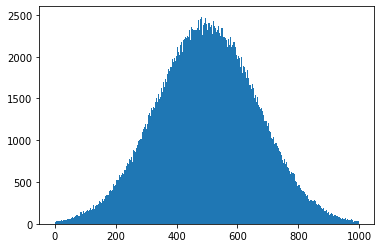

In [11]:
build_gassian_prototype()

In [12]:
dffema = pd.DataFrame(pd.read_excel(os.path.join(base_dir,fema_in_file),
                                    header=1,
                                    sheet_name='HELP',
                                    usecols=np.arange(12).tolist()))

In [13]:
headers = dffema.columns
dummy_index = dffema.index[-1]+1
clean()
create_dates_index()
display(dffema)
dffema_len = len(dffema)
df_orig = None
df = None

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1.0,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1.0,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1.0,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1.0,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1.0,70000.00,70000.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
950542,HOUSING ASSISTANCE RENTERS,NaN,53216,WI,2010,8,2010,8,NaN,0.00,3361725.14,0.00
950543,HOUSING ASSISTANCE RENTERS,NaN,53218,WI,2010,8,2010,8,NaN,0.00,3753216.85,0.00
950544,HOUSING ASSISTANCE RENTERS,NaN,53209,WI,2010,8,2010,8,NaN,0.00,4084102.26,0.00
950545,HOUSING ASSISTANCE RENTERS,NaN,53206,WI,2010,8,2010,8,NaN,0.00,4770400.99,0.00


In [14]:
def create_spend_report(colspend,display_result=True,save=False,test_sums=False):
    global df
    # update single month
    df.loc[df["months"]==1,"spend"] = df[df["months"]==1][colspend]

    # update first month in multi-month
    criteria = (df["mindex"]==0) & (df["months"]>1)
    df.loc[criteria,"spend"] = \
    df[criteria].apply(lambda x: (round((cdf[x["fraction"]-1]/cdftot)*x[colspend],2)),axis=1)
    
    # update non-first months in multi-month
    criteria = (df["mindex"]>0) & (df["months"]>1)
    df.loc[criteria,"spend"] = \
        df[criteria].apply(lambda x: (round(((cdf[(x["mindex"]+1)*x["fraction"]-1] \
                                              - cdf[x["mindex"]*x["fraction"]-1])/cdftot)*x[colspend],2)),axis=1)

    # adjust "middle" element to compensate for rounding error
    tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)["spend"].sum())
    df.loc[(df["months"]>1) \
                   & (df["mindex"] == (df["months"]/2).astype(int)),"spend"] += \
                        (df[(df["months"]>1) \
                                & (df["mindex"] \
                                   == (df["months"]/2).astype(int))][colspend] - tmp["spend"]).round(2)

    if test_sums:
        tmp = pd.DataFrame(df[df["months"]>1].groupby(axis=0,level=0)["spend"].sum())
        tmp2 = df[(df["months"]>1) & (df["mindex"]==1)]
        tmp3 = tmp2[((tmp2[colspend]-tmp["spend"]).abs().round(2))>0.0]
        if len(tmp3) != 0:
            print("The following rows failed the test...")
            display(tmp3)
        else:
            print("Passed!")
        

    # dispose of columns no longer needed
    df = df.drop(["TOTAL PROJECT SPEND","FED SPEND",
                          "STATE SPEND","months","mindex",
                          "fraction"],axis=1)

    # add dummy data, so that even date columns without data will be created
    # this row will not be included in final result since index will not match
    # any index in df_orig, but it will keep the columns, which is the point
    df = df.append(pd.DataFrame({"range":dti,"spend":0.0},
                                        index=np.ones(shape=len(dti),dtype=int)*dummy_index,
                                        columns=["range","spend"]))
    
    # pivot spend to date columns
    df = df.pivot(values="spend",columns="range")
    df.columns.name = ""
    
    # rejoin with original data
    df = df_orig.join(df)
    
    if display_result and not test_sums:
        display(df)

    if save and not test_sums:
        if colspend == "FED SPEND":
            filename = fema_fed_out_file
        elif colspend == "STATE SPEND":
            filename = fema_st_out_file
        else:
            filename = fema_tot_out_file
        filepath = os.path.join(base_dir,filename+".csv")
        fileexists = os.path.exists(filepath)
        df.to_csv(filepath, header=(not fileexists), \
                  mode=('a' if fileexists else 'w'))
        print(F"file written to: {filepath}")

In [15]:
def prep(copy_orig=True):
    global df
    if copy_orig:
        df = df_orig.copy()

    # add range column (list of n months from start to end, formate YYYY-MM)
    dt1 = pd.to_datetime(df["START MO"].astype(str) + " " \
                         + df["START YR"].astype(str))
    dt2 = pd.to_datetime(df["END MO"].astype(str) + " " \
                         + df["END YR"].astype(str)) + MonthEnd(0)
    df["range"] = [pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() \
                   for a, b in zip(dt1, dt2)]

    # add months column (n, single number per row, not a list)
    df["months"] = df["range"].apply(len)

    # add mindex column (0 to n-1)
    df["mindex"] = df["months"].apply(np.arange)

    # add spend column (list of n 0.0's, placeholder for the calculated spend later
    df["spend"] = df["months"].apply(np.zeros)

    # drop all but the above 4 columns + index
    df = df.drop(["FUND SOURCE","TYPE","COUNTY","STATE","START YR",\
                  "START MO","END YR","END MO","NUMBER OF MONTHS"],axis=1)

    # explode date, index and spend (each is a list with n elements)
    df = df.explode(["range","mindex","spend"])
    df["spend"] = df["spend"].astype(float)

    # add fraction column
    df["fraction"] = ((1/df["months"]).astype(float) * cdfbins).astype(int)

In [16]:
if dffema_len > 0:
    n=0
    while True:
        df = dffema[(dffema.index >= n*chunk_size) \
                    & (dffema.index < (n+1)*chunk_size)].copy()
        if len(df) > 0:
            df_orig = df.copy()
            prep(copy_orig=False)
            create_spend_report("TOTAL PROJECT SPEND",save=True)
            prep()
            create_spend_report("FED SPEND",save=True)
            prep()
            create_spend_report("STATE SPEND",save=True)
        print(F"iteration {n+1}: {len(df)} records read")
        n += 1
        if n*chunk_size > (dffema_len-1):
            break

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1.0,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1.0,2664.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1.0,22914.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1.0,70000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,PUBLIC ASSISTANCE,Severe Storm,Highland,OH,2008,10,2009,1,3.0,23480.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199996,PUBLIC ASSISTANCE,Severe Storm,Montgomery,OH,2008,10,2009,1,3.0,37286.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199997,PUBLIC ASSISTANCE,Severe Storm,Butler,OH,2008,10,2009,1,3.0,41855.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199998,PUBLIC ASSISTANCE,Severe Storm,Knox,OH,2008,10,2009,1,3.0,56760.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1.0,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1.0,2664.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1.0,22914.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1.0,70000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,PUBLIC ASSISTANCE,Severe Storm,Highland,OH,2008,10,2009,1,3.0,23480.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199996,PUBLIC ASSISTANCE,Severe Storm,Montgomery,OH,2008,10,2009,1,3.0,37286.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199997,PUBLIC ASSISTANCE,Severe Storm,Butler,OH,2008,10,2009,1,3.0,41855.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199998,PUBLIC ASSISTANCE,Severe Storm,Knox,OH,2008,10,2009,1,3.0,56760.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1.0,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1.0,2664.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1.0,22914.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1.0,70000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,PUBLIC ASSISTANCE,Severe Storm,Highland,OH,2008,10,2009,1,3.0,23480.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199996,PUBLIC ASSISTANCE,Severe Storm,Montgomery,OH,2008,10,2009,1,3.0,37286.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199997,PUBLIC ASSISTANCE,Severe Storm,Butler,OH,2008,10,2009,1,3.0,41855.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199998,PUBLIC ASSISTANCE,Severe Storm,Knox,OH,2008,10,2009,1,3.0,56760.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month.csv
iteration 1: 200000 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
200000,PUBLIC ASSISTANCE,Severe Storm,Franklin,OH,2008,10,2009,1,3.0,151230.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200001,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200002,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,-0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200003,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,3085.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200004,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,8571.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,PUBLIC ASSISTANCE,Flood,Statewide,MN,2014,7,2014,12,5.0,8062.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399996,PUBLIC ASSISTANCE,Flood,Lyon,MN,2014,7,2014,12,5.0,8420.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399997,PUBLIC ASSISTANCE,Flood,Statewide,MN,2014,7,2014,12,5.0,8467.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399998,PUBLIC ASSISTANCE,Flood,Faribault,MN,2014,7,2014,12,5.0,8473.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
200000,PUBLIC ASSISTANCE,Severe Storm,Franklin,OH,2008,10,2009,1,3.0,151230.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200001,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200002,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,-0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200003,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,3085.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200004,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,8571.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,PUBLIC ASSISTANCE,Flood,Statewide,MN,2014,7,2014,12,5.0,8062.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399996,PUBLIC ASSISTANCE,Flood,Lyon,MN,2014,7,2014,12,5.0,8420.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399997,PUBLIC ASSISTANCE,Flood,Statewide,MN,2014,7,2014,12,5.0,8467.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399998,PUBLIC ASSISTANCE,Flood,Faribault,MN,2014,7,2014,12,5.0,8473.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
200000,PUBLIC ASSISTANCE,Severe Storm,Franklin,OH,2008,10,2009,1,3.0,151230.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200001,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200002,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,-0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200003,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,3085.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200004,PUBLIC ASSISTANCE,Hurricane,Statewide,VI,2008,10,2009,1,3.0,8571.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,PUBLIC ASSISTANCE,Flood,Statewide,MN,2014,7,2014,12,5.0,8062.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399996,PUBLIC ASSISTANCE,Flood,Lyon,MN,2014,7,2014,12,5.0,8420.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399997,PUBLIC ASSISTANCE,Flood,Statewide,MN,2014,7,2014,12,5.0,8467.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399998,PUBLIC ASSISTANCE,Flood,Faribault,MN,2014,7,2014,12,5.0,8473.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month.csv
iteration 2: 200000 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
400000,PUBLIC ASSISTANCE,Flood,Freeborn,MN,2014,7,2014,12,5.0,8627.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400001,PUBLIC ASSISTANCE,Flood,Waseca,MN,2014,7,2014,12,5.0,8628.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400002,PUBLIC ASSISTANCE,Flood,Hennepin,MN,2014,7,2014,12,5.0,8661.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400003,PUBLIC ASSISTANCE,Flood,Steele,MN,2014,7,2014,12,5.0,8673.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400004,PUBLIC ASSISTANCE,Flood,Koochiching,MN,2014,7,2014,12,5.0,9005.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,PUBLIC ASSISTANCE,Hurricane,Passaic,NJ,2011,8,2012,6,10.0,35864.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599996,PUBLIC ASSISTANCE,Hurricane,Morris,NJ,2011,8,2012,6,10.0,36058.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599997,PUBLIC ASSISTANCE,Hurricane,Union,NJ,2011,8,2012,6,10.0,36358.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599998,PUBLIC ASSISTANCE,Hurricane,Statewide,NJ,2011,8,2012,6,10.0,36876.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
400000,PUBLIC ASSISTANCE,Flood,Freeborn,MN,2014,7,2014,12,5.0,8627.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400001,PUBLIC ASSISTANCE,Flood,Waseca,MN,2014,7,2014,12,5.0,8628.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400002,PUBLIC ASSISTANCE,Flood,Hennepin,MN,2014,7,2014,12,5.0,8661.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400003,PUBLIC ASSISTANCE,Flood,Steele,MN,2014,7,2014,12,5.0,8673.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400004,PUBLIC ASSISTANCE,Flood,Koochiching,MN,2014,7,2014,12,5.0,9005.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,PUBLIC ASSISTANCE,Hurricane,Passaic,NJ,2011,8,2012,6,10.0,35864.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599996,PUBLIC ASSISTANCE,Hurricane,Morris,NJ,2011,8,2012,6,10.0,36058.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599997,PUBLIC ASSISTANCE,Hurricane,Union,NJ,2011,8,2012,6,10.0,36358.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599998,PUBLIC ASSISTANCE,Hurricane,Statewide,NJ,2011,8,2012,6,10.0,36876.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
400000,PUBLIC ASSISTANCE,Flood,Freeborn,MN,2014,7,2014,12,5.0,8627.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400001,PUBLIC ASSISTANCE,Flood,Waseca,MN,2014,7,2014,12,5.0,8628.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400002,PUBLIC ASSISTANCE,Flood,Hennepin,MN,2014,7,2014,12,5.0,8661.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400003,PUBLIC ASSISTANCE,Flood,Steele,MN,2014,7,2014,12,5.0,8673.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400004,PUBLIC ASSISTANCE,Flood,Koochiching,MN,2014,7,2014,12,5.0,9005.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,PUBLIC ASSISTANCE,Hurricane,Passaic,NJ,2011,8,2012,6,10.0,35864.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599996,PUBLIC ASSISTANCE,Hurricane,Morris,NJ,2011,8,2012,6,10.0,36058.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599997,PUBLIC ASSISTANCE,Hurricane,Union,NJ,2011,8,2012,6,10.0,36358.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599998,PUBLIC ASSISTANCE,Hurricane,Statewide,NJ,2011,8,2012,6,10.0,36876.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month.csv
iteration 3: 200000 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
600000,PUBLIC ASSISTANCE,Hurricane,Morris,NJ,2011,8,2012,6,10.0,38468.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600001,PUBLIC ASSISTANCE,Hurricane,Passaic,NJ,2011,8,2012,6,10.0,38550.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600002,PUBLIC ASSISTANCE,Hurricane,Monmouth,NJ,2011,8,2012,6,10.0,39243.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600003,PUBLIC ASSISTANCE,Hurricane,Hunterdon,NJ,2011,8,2012,6,10.0,39308.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600004,PUBLIC ASSISTANCE,Hurricane,Somerset,NJ,2011,8,2012,6,10.0,39361.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,HOUSING ASSISTANCE OWNERS,NaN,50134,IA,2020,8,2020,8,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799996,HOUSING ASSISTANCE OWNERS,NaN,33625,FL,2012,7,2012,7,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799997,HOUSING ASSISTANCE OWNERS,NaN,70374,LA,2005,9,2005,9,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799998,HOUSING ASSISTANCE OWNERS,NaN,39665,MS,2003,4,2003,4,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
600000,PUBLIC ASSISTANCE,Hurricane,Morris,NJ,2011,8,2012,6,10.0,38468.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600001,PUBLIC ASSISTANCE,Hurricane,Passaic,NJ,2011,8,2012,6,10.0,38550.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600002,PUBLIC ASSISTANCE,Hurricane,Monmouth,NJ,2011,8,2012,6,10.0,39243.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600003,PUBLIC ASSISTANCE,Hurricane,Hunterdon,NJ,2011,8,2012,6,10.0,39308.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600004,PUBLIC ASSISTANCE,Hurricane,Somerset,NJ,2011,8,2012,6,10.0,39361.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,HOUSING ASSISTANCE OWNERS,NaN,50134,IA,2020,8,2020,8,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799996,HOUSING ASSISTANCE OWNERS,NaN,33625,FL,2012,7,2012,7,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799997,HOUSING ASSISTANCE OWNERS,NaN,70374,LA,2005,9,2005,9,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799998,HOUSING ASSISTANCE OWNERS,NaN,39665,MS,2003,4,2003,4,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
600000,PUBLIC ASSISTANCE,Hurricane,Morris,NJ,2011,8,2012,6,10.0,38468.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600001,PUBLIC ASSISTANCE,Hurricane,Passaic,NJ,2011,8,2012,6,10.0,38550.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600002,PUBLIC ASSISTANCE,Hurricane,Monmouth,NJ,2011,8,2012,6,10.0,39243.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600003,PUBLIC ASSISTANCE,Hurricane,Hunterdon,NJ,2011,8,2012,6,10.0,39308.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600004,PUBLIC ASSISTANCE,Hurricane,Somerset,NJ,2011,8,2012,6,10.0,39361.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,HOUSING ASSISTANCE OWNERS,NaN,50134,IA,2020,8,2020,8,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799996,HOUSING ASSISTANCE OWNERS,NaN,33625,FL,2012,7,2012,7,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799997,HOUSING ASSISTANCE OWNERS,NaN,70374,LA,2005,9,2005,9,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799998,HOUSING ASSISTANCE OWNERS,NaN,39665,MS,2003,4,2003,4,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month.csv
iteration 4: 199903 records read


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
800000,HOUSING ASSISTANCE OWNERS,NaN,33313,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800001,HOUSING ASSISTANCE OWNERS,NaN,33325,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800002,HOUSING ASSISTANCE OWNERS,NaN,7734,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800003,HOUSING ASSISTANCE OWNERS,NaN,43025,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800004,HOUSING ASSISTANCE OWNERS,NaN,33221,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950542,HOUSING ASSISTANCE RENTERS,NaN,53216,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950543,HOUSING ASSISTANCE RENTERS,NaN,53218,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950544,HOUSING ASSISTANCE RENTERS,NaN,53209,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950545,HOUSING ASSISTANCE RENTERS,NaN,53206,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_total_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
800000,HOUSING ASSISTANCE OWNERS,NaN,33313,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800001,HOUSING ASSISTANCE OWNERS,NaN,33325,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800002,HOUSING ASSISTANCE OWNERS,NaN,7734,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800003,HOUSING ASSISTANCE OWNERS,NaN,43025,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800004,HOUSING ASSISTANCE OWNERS,NaN,33221,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950542,HOUSING ASSISTANCE RENTERS,NaN,53216,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950543,HOUSING ASSISTANCE RENTERS,NaN,53218,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950544,HOUSING ASSISTANCE RENTERS,NaN,53209,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950545,HOUSING ASSISTANCE RENTERS,NaN,53206,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_fed_by_month.csv


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2107-12,2108-01,2108-02,2108-03,2108-04,2108-05,2108-06,2108-07,2108-08,2108-09
800000,HOUSING ASSISTANCE OWNERS,NaN,33313,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800001,HOUSING ASSISTANCE OWNERS,NaN,33325,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800002,HOUSING ASSISTANCE OWNERS,NaN,7734,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800003,HOUSING ASSISTANCE OWNERS,NaN,43025,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800004,HOUSING ASSISTANCE OWNERS,NaN,33221,FL,2017,9,2017,9,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950542,HOUSING ASSISTANCE RENTERS,NaN,53216,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950543,HOUSING ASSISTANCE RENTERS,NaN,53218,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950544,HOUSING ASSISTANCE RENTERS,NaN,53209,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950545,HOUSING ASSISTANCE RENTERS,NaN,53206,WI,2010,8,2010,8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


file written to: /content/drive/MyDrive/environment/fema_state_by_month.csv
iteration 5: 150546 records read
